# Can Bad Teaching Induce Forgetting? Unlearning in Deep Networks using an Incompetent Teacher - Vikram S Chundawat et al
<center>

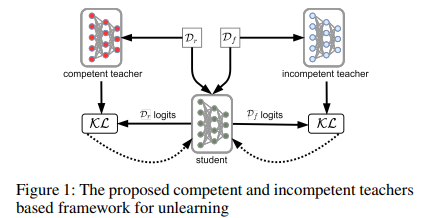</center>

### Terminologies
 - Comptetent Teacher - Model trained on entire dataset D
 - Incompetent Teacher - Randomly Initialised Model
 - Student Model - Same weights as Competent Teacher
 - D => Total train Data, Df => Data to forget, Dr = D - Df => Retain Data
 - l<sub>u</sub> => Pesudo label. l<sub>ui</sub>=1 if x<sub>i</sub> belongs to forget data else l<sub>ui</sub>=0
 - KL => KL Divergence


### Unlearning Objective Function
 <center>

 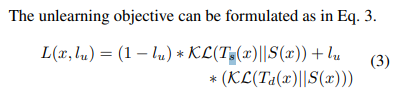

 </center>

In [1]:
from torchvision.datasets import CIFAR100
from torch.utils.data import DataLoader
from torchvision.models import resnet18
from torch import nn
import torch
from tqdm import tqdm
from torch.nn import functional as F
from torch.optim import Adam
from torchvision import transforms

## Dataset Preparation

In [2]:
transform_train = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

class customCIFAR100(CIFAR100):
    def __init__(self, root, train, download, transform):
        super().__init__(root = root, train = train, download = download, transform = transform)
        self.coarse_map = {
            0:[4, 30, 55, 72, 95],
            1:[1, 32, 67, 73, 91],
            2:[54, 62, 70, 82, 92],
            3:[9, 10, 16, 28, 61],
            4:[0, 51, 53, 57, 83],
            5:[22, 39, 40, 86, 87],
            6:[5, 20, 25, 84, 94],
            7:[6, 7, 14, 18, 24],
            8:[3, 42, 43, 88, 97],
            9:[12, 17, 37, 68, 76],
            10:[23, 33, 49, 60, 71],
            11:[15, 19, 21, 31, 38],
            12:[34, 63, 64, 66, 75],
            13:[26, 45, 77, 79, 99],
            14:[2, 11, 35, 46, 98],
            15:[27, 29, 44, 78, 93],
            16:[36, 50, 65, 74, 80],
            17:[47, 52, 56, 59, 96],
            18:[8, 13, 48, 58, 90],
            19:[41, 69, 81, 85, 89]
        }
    def __getitem__(self,index):
        x, y = super().__getitem__(index)
        coarse_y = None
        for i in range(20):
            for j in self.coarse_map[i]:
                if y == j:
                    coarse_y = i
                    break
            if coarse_y != None:
                break
        if coarse_y == None:
            print(y)
            assert coarse_y != None
        return x, y, coarse_y

In [3]:
train_ds = customCIFAR100(root=".",train=True,download=True,transform=transform_train)
test_ds = customCIFAR100(root=".",train=False,download=True,transform = transform_test)

100%|██████████| 169M/169M [00:02<00:00, 80.3MB/s] 


In [4]:
train_dl = DataLoader(train_ds,batch_size=256, shuffle=True)
test_dl = DataLoader(test_ds,batch_size=256, shuffle=True)

## Resnet18 Model

In [5]:
class Model(nn.Module):
    def __init__(self,num_classes, pretrained):
        super().__init__()
        base = resnet18(pretrained=pretrained)
        self.base = nn.Sequential(*list(base.children())[:-1])
        in_features = base.fc.in_features
        self.drop = nn.Dropout()
        self.final = nn.Linear(in_features,num_classes)
    
    def forward(self,x):
        x = self.base(x)
        x = self.drop(x.view(-1,self.final.in_features))
        return self.final(x)

In [6]:
num_classes  = 20
pretrained = True
model = Model(num_classes,pretrained).to('cuda')

print("Loaded the model with pretrained weights")

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 149MB/s] 


Loaded the model with pretrained weights


## Training and Evaluation Loop

In [7]:
import torch
import torch.nn.functional as F

def evaluate(model, dataloader, device):
    model.eval()  # set to evaluation mode
    correct = 0
    total = 0
    loss_track = []

    with torch.no_grad():
        for x, _, y in dataloader:
            x, y = x.to(device), y.to(device)
            predictions = model(x)

            loss = F.cross_entropy(predictions, y)
            loss_track.append(loss.item())

            _, preds = torch.max(predictions, dim=1)
            correct += (preds == y).sum().item()
            total += y.size(0)

    avg_loss = sum(loss_track) / len(loss_track)
    accuracy = correct / total

    return avg_loss, accuracy

In [8]:
def train(model,train_loader,val_loader,epochs,device):
    optimizer = Adam(model.parameters(),lr=0.001)
    for epoch in tqdm(range(epochs)):
        model.train()
        batch_loss = []
        for batch_idx,(x,_,y) in enumerate(train_loader):
            x,y = x.to(device),y.to(device)
            predictions = model(x)
            loss = F.cross_entropy(predictions,y)
            batch_loss.append(loss.item())
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        val_loss,val_acc = evaluate(model,val_loader,device)

        print(f"Epoch: {epoch} | Train Loss: {sum(batch_loss)/len(batch_loss):.4f} | Val Loss: {val_loss:.4f} | Val Accuracy: {val_acc:.4f}")

In [9]:
train(model,train_dl,test_dl,5,'cuda')

 20%|██        | 1/5 [02:21<09:26, 141.61s/it]

Epoch: 0 | Train Loss: 1.0764 | Val Loss: 0.9541 | Val Accuracy: 0.6981


 40%|████      | 2/5 [04:31<06:43, 134.48s/it]

Epoch: 1 | Train Loss: 0.6190 | Val Loss: 0.7484 | Val Accuracy: 0.7591


 60%|██████    | 3/5 [06:41<04:25, 132.60s/it]

Epoch: 2 | Train Loss: 0.4237 | Val Loss: 0.7383 | Val Accuracy: 0.7754


 80%|████████  | 4/5 [08:51<02:11, 131.63s/it]

Epoch: 3 | Train Loss: 0.2906 | Val Loss: 0.8885 | Val Accuracy: 0.7450


100%|██████████| 5/5 [11:01<00:00, 132.21s/it]

Epoch: 4 | Train Loss: 0.1990 | Val Loss: 0.7950 | Val Accuracy: 0.7782


In [10]:
torch.save(model.state_dict(), "Resnet18_CIFAR100_5_Epochs.pt")

# Scenerio 1: Class Level Unlearning
## Forget Dataset Preparation

In [11]:
from torch.utils.data import Subset
import random

In [12]:
#69->rocket class
indices_to_retain_train = [i for i, (_,label,_) in enumerate(train_ds) if label!=69]
indices_to_forget_train = [i for i, (_,label,_) in enumerate(train_ds) if label==69]

indices_to_retain_test = [i for i, (_,label,_) in enumerate(test_ds) if label!=69]
indices_to_forget_test = [i for i, (_,label,_) in enumerate(test_ds) if label==69]


retain_train_ds = Subset(train_ds,indices_to_retain_train)
forget_train_ds = Subset(train_ds,indices_to_forget_train)

retain_test_ds = Subset(test_ds,indices_to_retain_test)
forget_test_ds = Subset(test_ds,indices_to_forget_test)

sampled_retain_train_indices = random.sample(indices_to_retain_train, int(0.3*len(indices_to_retain_train)))
sampled_retain_train_ds = Subset(train_ds,sampled_retain_train_indices)

retain_test_dl = DataLoader(retain_test_ds,batch_size=256,shuffle=True)
forget_test_dl = DataLoader(forget_test_ds,batch_size=256,shuffle=True)

In [15]:
evaluate(model,retain_test_dl,'cuda') #Loss,Accuracy on Trained Model on Retain Dataset

(0.7856663694748511, 0.7790909090909091)

In [16]:
evaluate(model,forget_test_dl,'cuda') #Loss,Accuracy on Trained Model on Forget Dataset

(1.1042251586914062, 0.69)

In [17]:
from torch.utils.data import Dataset

In [35]:
class ModifiedDataset(Dataset):
    def __init__(self,forget_ds,retain_ds):
        self.forget_ds = forget_ds
        self.retain_ds = retain_ds
        self.len_forget_ds = len(forget_ds)
        self.len_retain_ds = len(retain_ds)
        
    def __len__(self):
        return self.len_forget_ds+self.len_retain_ds
        
    def __getitem__(self,index):
        if index<self.len_forget_ds:
            x = self.forget_ds[index][0]
            y = 1
        else:
            x = self.retain_ds[index- self.len_forget_ds][0]
            y = 0
        return x,y

In [39]:
unlearning_train_ds = ModifiedDataset(forget_train_ds,sampled_retain_train_ds)
unlearning_train_dl = DataLoader(unlearning_train_ds,batch_size=256,shuffle=True)

In [44]:
good_teacher = model

student = Model(num_classes = 20, pretrained = True).to('cuda')
student.load_state_dict(torch.load("/kaggle/working/Resnet18_CIFAR100_5_Epochs.pt", map_location='cuda'))

bad_teacher = Model(num_classes = 20, pretrained = True).to('cuda')

In [45]:
def bad_teacher_unlearning(student,bad_teacher,good_teacher,unlearning_loader,epochs,device):
    optimizer = Adam(student.parameters(),lr = 0.001)
    for epoch in tqdm(range(epochs)):
        student.train()
        bad_teacher.eval()
        good_teacher.eval()
        for batch_idx,(x,y) in enumerate(unlearning_loader):
            x,y = x.to(device),y.to(device)
            with torch.no_grad():
                bad_teacher_logits = F.softmax(bad_teacher(x),dim=1)
                good_teacher_logits =  F.softmax(good_teacher(x),dim=1)

            student_logits = F.log_softmax(student(x),dim=1)
            labels = torch.unsqueeze(y, dim = 1)
            combined_teacher_out = labels*bad_teacher_logits+(1-labels)*good_teacher_logits

            loss = F.kl_div(student_logits,combined_teacher_out)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

In [46]:
bad_teacher_unlearning(student,bad_teacher,good_teacher,unlearning_train_dl,1,'cuda')

100%|██████████| 1/1 [00:35<00:00, 35.47s/it]


In [47]:
evaluate(student,retain_test_dl,'cuda') #Loss,Accuracy on Unlearnt Model on Retain Dataset

(0.7543732248819791, 0.768989898989899)

In [48]:
evaluate(student,forget_test_dl,'cuda') #Loss,Accuracy on Unlearnt Model on Forget Dataset

(3.1197502613067627, 0.05)

## Inferences:

1. Before Unlearning: Forget_test_dl had accuracy 69% now it has dropped to 5% in one epoch.
2. Before Unlearning: Retain_test_dl had accuracy 77% now  it has almost remained same around 76.8%  in one epoch.

# Scenerio 2: Random Sample Unlearning

In [54]:
# Total indices in train_ds
all_train_indices = list(range(len(train_ds)))

# Randomly select 100 indices to forget
indices_to_forget_train = random.sample(all_train_indices, 100)

# The remaining indices to retain
indices_to_retain_train = list(set(all_train_indices) - set(indices_to_forget_train))

# Create Subset datasets
retain_train_ds = Subset(train_ds, indices_to_retain_train)
forget_train_ds = Subset(train_ds, indices_to_forget_train)

sampled_retain_train_indices = random.sample(indices_to_retain_train, int(0.3*len(indices_to_retain_train)))
sampled_retain_train_ds = Subset(train_ds,sampled_retain_train_indices)

# Now, if you still want test loaders for the original test set, you can create them too
retain_test_dl = DataLoader(test_ds, batch_size=256, shuffle=True)  # no filtering for test
forget_train_dl = DataLoader(forget_train_ds, batch_size=256, shuffle=True)  # no filtering for test

In [52]:
evaluate(model,retain_test_dl,'cuda') #Loss,Accuracy on Trained Model on Retain  Test Dataset

(0.7858209431171417, 0.7782)

In [53]:
evaluate(model,forget_train_dl,'cuda') #Loss,Accuracy on Trained Model on Forget Train Dataset

(0.16715684533119202, 0.95)

In [55]:
unlearning_train_ds = ModifiedDataset(forget_train_ds,sampled_retain_train_ds)
unlearning_train_dl = DataLoader(unlearning_train_ds,batch_size=256,shuffle=True)

In [56]:
good_teacher = model

student = Model(num_classes = 20, pretrained = True).to('cuda')
student.load_state_dict(torch.load("/kaggle/working/Resnet18_CIFAR100_5_Epochs.pt", map_location='cuda'))

bad_teacher = Model(num_classes = 20, pretrained = True).to('cuda')

In [57]:
bad_teacher_unlearning(student,bad_teacher,good_teacher,unlearning_train_dl,1,'cuda')

100%|██████████| 1/1 [00:34<00:00, 34.51s/it]


In [58]:
evaluate(model,retain_test_dl,'cuda') #Loss,Accuracy on Unlearnt Model on Retain  Test Dataset

(0.7949635028839112, 0.7782)

In [59]:
evaluate(model,forget_train_dl,'cuda') #Loss,Accuracy on Unlearnt Model on Forget Train Dataset

(0.3614567220211029, 0.88)

## Inferences:

1. Before Unlearning: Forget_test_dl had accuracy 95% now it has dropped to 88% in one epoch.[Not much of a drop]
2. Before Unlearning: Retain_test_dl had accuracy 77% now  it has almost remained same around 77%  in one epoch.

***Important:* To analyze the performance of proposed method due to the impact of proportion of forget samples to the sample fraction of retain data**